In [12]:
# importing libraries
import h5py
import scipy.io as sio
import PIL.Image as Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import os
from tqdm import tqdm  # For nice progress bar!
%matplotlib inline

# Check the ground true using scipy

image_info 是 matlab structs，本质是一个数组，维度是（1，1），读取后是一个 NumPy structured arrays，with fields named for the struct fields。这个元素存着所有的值,把维度挤出来需要 squeeze_me=True。

这个数据有两个字段，location 表示人头的位置，number 表示人头数

> In the SciPy versions from 0.12.0, MATLAB structs come back as NumPy structured arrays, with fields named for the struct fields.

> Sometimes, it’s more convenient to load the MATLAB structs as Python objects rather than NumPy structured arrays - it can make the access syntax in Python a bit more similar to that in MATLAB. In order to do this, use the struct_as_record=False parameter setting to loadmat.


In [3]:
mat_data = sio.loadmat(
    "./dataset/shanghaitech/part_A/train_data/ground-truth/GT_IMG_1.mat")
mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 20:06:05 2016',
 '__version__': '1.0',
 '__globals__': [],
 'image_info': array([[array([[(array([[ 29.6225116 , 472.92022152],
                        [ 54.35533603, 454.96602305],
                        [ 51.79045053, 460.46220626],
                        ...,
                        [597.89732076, 688.27900015],
                        [965.77518336, 638.44693908],
                        [166.9965574 , 628.1873971 ]]), array([[1546]], dtype=uint16))]],
               dtype=[('location', 'O'), ('number', 'O')])                               ]],
       dtype=object)}

In [4]:
gt_image = mat_data['image_info']
print(gt_image)
val = gt_image[0][0]
print(val)

[[array([[(array([[ 29.6225116 , 472.92022152],
                 [ 54.35533603, 454.96602305],
                 [ 51.79045053, 460.46220626],
                 ...,
                 [597.89732076, 688.27900015],
                 [965.77518336, 638.44693908],
                 [166.9965574 , 628.1873971 ]]), array([[1546]], dtype=uint16))]],
        dtype=[('location', 'O'), ('number', 'O')])                               ]]
[[(array([[ 29.6225116 , 472.92022152],
         [ 54.35533603, 454.96602305],
         [ 51.79045053, 460.46220626],
         ...,
         [597.89732076, 688.27900015],
         [965.77518336, 638.44693908],
         [166.9965574 , 628.1873971 ]]), array([[1546]], dtype=uint16))]]


In [5]:
print(val['location'])
print(val['number'])

[[array([[ 29.6225116 , 472.92022152],
         [ 54.35533603, 454.96602305],
         [ 51.79045053, 460.46220626],
         ...,
         [597.89732076, 688.27900015],
         [965.77518336, 638.44693908],
         [166.9965574 , 628.1873971 ]])]]
[[array([[1546]], dtype=uint16)]]


In [6]:
print(val['location'][0, 0].shape)  # (1546, 2) 1546个人头

(1546, 2)


In [7]:
print(gt_image[0, 0][0, 0][0])
print(gt_image[0, 0][0, 0][0].shape)
print(len(gt_image[0, 0][0, 0][0]))

[[ 29.6225116  472.92022152]
 [ 54.35533603 454.96602305]
 [ 51.79045053 460.46220626]
 ...
 [597.89732076 688.27900015]
 [965.77518336 638.44693908]
 [166.9965574  628.1873971 ]]
(1546, 2)
1546


In [8]:
gt_image[0, 0]['location'][0, 0]

array([[ 29.6225116 , 472.92022152],
       [ 54.35533603, 454.96602305],
       [ 51.79045053, 460.46220626],
       ...,
       [597.89732076, 688.27900015],
       [965.77518336, 638.44693908],
       [166.9965574 , 628.1873971 ]])

# View density map using h5py


[[[255 254 255]
  [251 250 255]
  [252 251 255]
  ...
  [235 236 240]
  [236 237 241]
  [237 238 240]]

 [[252 251 255]
  [253 252 255]
  [250 249 254]
  ...
  [242 243 247]
  [230 231 235]
  [220 221 223]]

 [[250 249 254]
  [255 254 255]
  [255 254 255]
  ...
  [223 224 228]
  [225 226 230]
  [230 231 233]]

 ...

 [[242 171 201]
  [240 169 199]
  [238 167 197]
  ...
  [206 180 165]
  [205 179 164]
  [204 178 163]]

 [[239 168 198]
  [237 166 196]
  [237 164 194]
  ...
  [210 184 169]
  [209 183 168]
  [208 182 167]]

 [[238 165 195]
  [237 164 194]
  [234 161 191]
  ...
  [213 187 172]
  [212 186 171]
  [211 185 170]]]


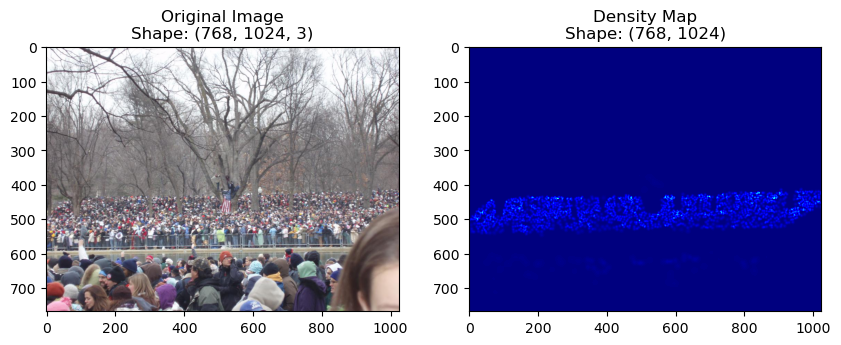

In [9]:
density_map_path = "./dataset/shanghaitech/part_A/train_data/density-maps/IMG_1.h5"
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
with h5py.File(density_map_path, "r") as hf:
  density_img = np.asarray(hf['density'])
  orginal_img = np.asarray(Image.open(density_map_path.replace(
      "density-maps", "images").replace("h5", "jpg")))
  print(orginal_img)
  axs[0].imshow(orginal_img)
  axs[0].set_title('Original Image\nShape: {}'.format(
      orginal_img.shape))  # 设置子图标题

  axs[1].imshow(density_img, cmap=CM.jet)
  axs[1].set_title('Density Map\nShape: {}'.format(
      density_img.shape))  # 设置子图标题

# Count number of people

离散密度图求和就是人头数，使用高斯核平滑后，每个像素值的会有所改变，但是求和起来仍然是人头数


In [7]:
np.sum(density_img)

1543.841

# Parallel for loops using joblib

The core idea is to write the code to be executed as a generator expression, and convert it to parallel computing

1. 使用这个库进行并行时，核心是先写一个 generator，如何在使用平行计算
2. 这个并行计算可以返回一个 generator，并且只有 generator 里面有值就可以先返回给你看，即使并行还没计算完。返回的顺序可以按照提交的顺序。

> The output can be a generator that yields the results as soon as they’re available, even if the subsequent tasks aren’t completed yet. The order of the outputs always matches the order the inputs have been submitted with:


# Check the ShanghaitechDateset

检查一下封装好的数据集，因为pytorch中，每个batchsize里的所有数据的dimension必须一样，这样才能高效计算，所以batchsize只能设置为1


In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from src.custom_dataset import ShanghaitechDataset
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as CM

240 60


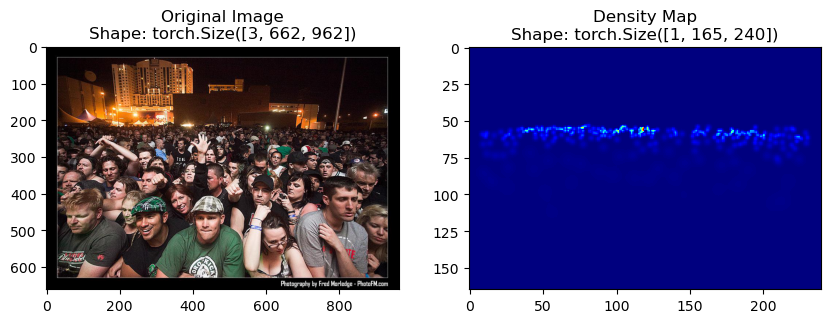

In [2]:
A_dir = os.path.join(os.getcwd(), "dataset/shanghaitech/part_A/")
A_dir

orginal_img_dir = os.path.join(A_dir, "train_data", "images")
density_map_dir = os.path.join(A_dir, "train_data", "density-maps")
csv_file = os.path.join(A_dir, "train_data", "shanghaitech.csv")

my_transforms = transforms.Compose([
    
    # toTensor就会使数据集缩放到[0,1]
    transforms.ToTensor(),
    # pytoch官方在imagenet上计算的mean和std
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                                  std=[0.229, 0.224, 0.225]),
])
shanghaitechDataset = ShanghaitechDataset(
    orginal_img_dir=orginal_img_dir, density_map_dir=density_map_dir, cvs_file=csv_file, transform=my_transforms)
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    shanghaitechDataset, [0.8, 0.2], generator1)

train_dataloader = DataLoader(
    train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, 1, shuffle=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
print(len(train_dataset),len(val_dataset))
for X,Y in train_dataloader:
    axs[0].imshow(torch.squeeze(X).permute(1,2,0))
    axs[0].set_title('Original Image\nShape: {}'.format(
      torch.squeeze(X).shape))  # 设置子图标题

    axs[1].imshow(torch.squeeze(Y), cmap=CM.jet)
    axs[1].set_title('Density Map\nShape: {}'.format(
      torch.squeeze(Y,dim=0).shape))  # 设置子图标题
    break

In [4]:
from tqdm import tqdm
def get_mean_std(loader):
  # var[X] = E[X**2] - E[X]**2
  channels_sum, channels_sqrd_sum, num_batches = 0,0,0
  for data, _ in tqdm(loader):
    # 第1个维度表示channel数量，把0，2，3维度求均值，最后只会保留channel数量，意味着把一个批次的数据集，在channel的地方求了均值
    channels_sum += torch.mean(data, dim=[0, 2, 3])
    channels_sqrd_sum += torch.mean(data**2, dim=[0, 2, 3])
    num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean**2) ** 0.5
    
  print(num_batches)
  return mean, std
  
mean, std = get_mean_std(train_dataloader)
print(mean,std)

100%|██████████| 240/240 [00:02<00:00, 82.79it/s]

240
tensor([0.4112, 0.3684, 0.3560]) tensor([0.2829, 0.2727, 0.2738])


# Check the model

In [34]:
from src.models import mcnn

In [49]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)
model = mcnn(in_channels=3).to(device)
for _,m in enumerate(model.modules()):
    print(_)
    print(m)
X = torch.randn(5,3,224,224).to(device)
pred = model(X)
print(pred.shape)
print(torch.sum(pred,dim=[2,3]).shape)

mps
0
mcnn(
  (branch1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (9): ReLU()
  )
  (branch2): Sequential(
    (0): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(40, 20, kernel_size=(5, 5), stride=(1, 1), padding=

# Check the loss

In [32]:
a = 3.7
print(f"取整：{torch.ceil(torch.tensor(a))}")

取整：4.0


In [48]:
a = torch.randint(-5,5,(3,1))
print(a)
print(torch.mean(a,dim=0,dtype=torch.float32))
print(torch.mean(a,dtype=torch.float32))
print(torch.mean(a,dtype=torch.float32).item())
print(torch.abs(a))

tensor([[-1],
        [ 1],
        [-5]])
tensor([-1.6667])
tensor(-1.6667)
-1.6666666269302368
tensor([[1],
        [1],
        [5]])


In [29]:
import torch
from torch import nn

loss_fn = nn.MSELoss(reduction="sum")
Y = torch.ones((2,1,2,2))
print(Y)
pred = torch.randint(low=0,high=5,size=(2,1,2,2),generator=torch.manual_seed(21)
)
print(pred)
print((pred - Y) ** 2)

loss = loss_fn(pred,Y)

print(loss)
# print(loss.shape)



tensor([[[[1., 1.],
          [1., 1.]]],


        [[[1., 1.],
          [1., 1.]]]])
tensor([[[[3, 3],
          [1, 3]]],


        [[[1, 4],
          [0, 4]]]])
tensor([[[[4., 4.],
          [0., 4.]]],


        [[[0., 9.],
          [1., 9.]]]])
tensor(31.)
